In [ ]:
!apt-get install -qq libgdal-dev libproj-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy
!pip install regionmask


#!pip install regionmask
#!pip install cartopy

#!pip install -q --upgrade ipython
#!pip install -q --upgrade ipykernel

In [ ]:
#import required packages
import os
import warnings
import time
import regionmask
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import shapely
from datetime import datetime as dt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.interpolate import interp1d
from dateutil.relativedelta import relativedelta
from google.colab import drive
from google.colab import files

In [ ]:
#establish working directory and mount drive
drive.mount('/content/drive')
working_directory = '/content/drive/My Drive/COS Seesaw Research'

Mounted at /content/drive


Parallel site arrays for constructing regions, and time delta for building feature time series in addition, contains the radius for defining map regions

In [ ]:
cos_sites = ['alt', 'brw', 'cgo', 'hfm', 'kum', 'lef', 'mhd', 'mlo', 'nwr', 'psa', 'smo', 'spo', 'sum', 'thd']
cos_site_centers = [(-62.3, 82.5), (-156.6, 71.3), (144.7,-40.7), (-72.2, 42.5), (-154.8, 19.5), (-90.3, 45.6), (-9.9, 53.3), (-155.6, 19.5), (-105.5, 40.1), (-64.0, -64.6), (-170.6, -14.2), (0, -90), (-38.4, 72.6), (-124.1,41.0)]
time_delta_general = [('-15d', relativedelta(days=-15)), ('-1m', relativedelta(months=-1)), ('-1m15d', relativedelta(months=-1, days=-15)), ('-2m', relativedelta(months=-2))]
region_size = 30
year_start = 2000
year_end = 2018
divider = ('-------------------------------------------------------------------------------------------------------')

Build regions

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


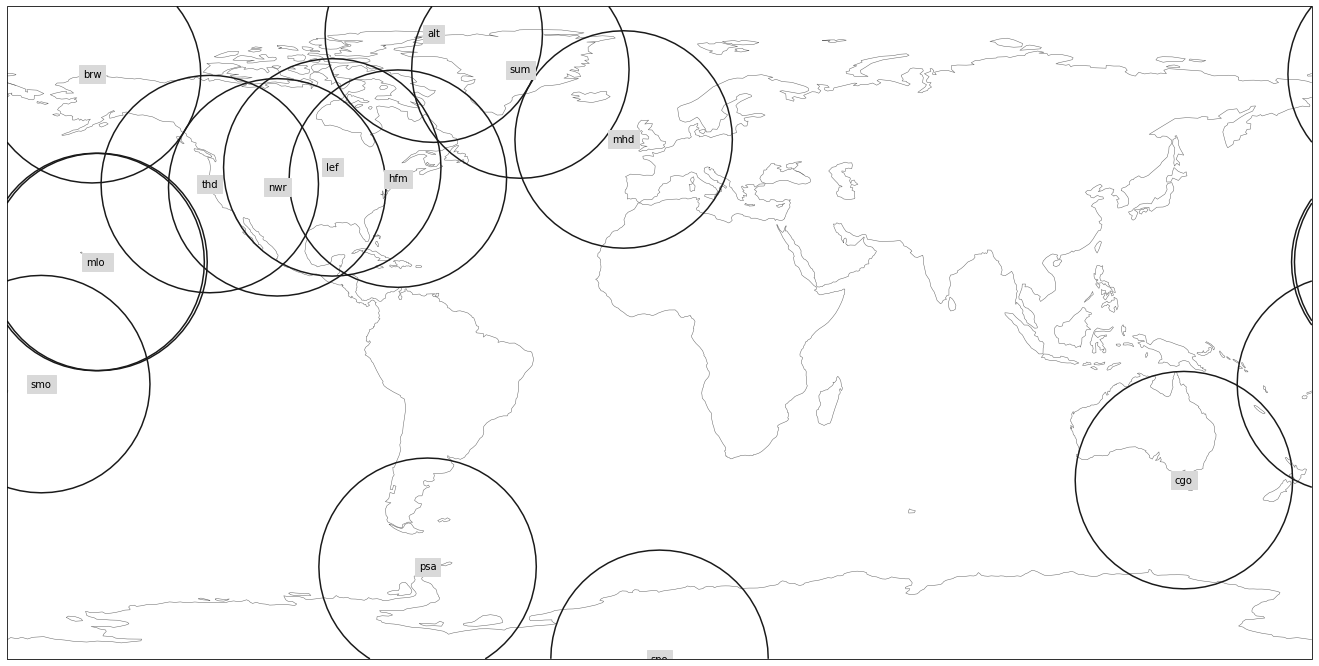

In [ ]:
regions = None
names = []
abbrevs = []
region_list = []

for i in range(len(cos_sites)):
  names.append(cos_sites[i])
  abbrevs.append(cos_sites[i])
  center_point = Point(cos_site_centers[i][0], cos_site_centers[i][1])
  circle = center_point.buffer(region_size)

  #region_bound = np.array([list(cos_site_centers[i])])
  
  #region_list.append(region_bound)
  region_list.append(circle)

regions = regionmask.Regions(region_list, names=names, abbrevs=abbrevs, name='Ocean Regions', overlap=True)
plt.figure(figsize=(24,12))
regions.plot(label='abbrev')
plt.show()

Establish dictionary of different data frames, one for each of the observation sites

In [ ]:
days = pd.date_range(start=dt(year=2005, month=1, day=1), end=dt(year=2017, month=1, day=1), freq='SM')
days_frame = pd.DataFrame({'time':days})

'\nfile_name = working_directory + \'/Data/OCS/OCS__GCMS_flask.txt\'\ntime_column_name = \'yyyymmdd\'\ncos_data_full = pd.read_csv(file_name, delim_whitespace=True, header=1, parse_dates=[time_column_name])\nfor site in cos_sites:\n  print(\'Initializing data frame for \', site)\n  cos_data = cos_data_full.loc[cos_data_full[\'site\'] == site]\n  duplicates = cos_data.duplicated(keep=False, subset=[time_column_name])\n  duplicate_entries = cos_data.where(duplicates)\n  duplicate_entries.dropna(inplace=True)\n  unique_dates = duplicate_entries[time_column_name].unique()\n  same_day_avg = []\n  for date in unique_dates:\n    entry_subset = duplicate_entries.where(duplicate_entries[time_column_name] == date)\n    entry_subset.dropna(inplace=True)\n    ocs_col = entry_subset[\'OCS_\']\n    mean = ocs_col.mean()\n    same_day_avg.append((date,mean))\n  cos_data = cos_data.drop_duplicates(subset=[time_column_name])\n \n  for avg in same_day_avg:\n    cos_data.loc[cos_data[time_column_name] ==

Helper function for getting regionalized data

In [ ]:
def standardize_longitude(data):
    print(divider)
    print('Standardizing Longitude')
    print(divider)
    data = data.assign_coords(lon = (((data.lon + 180) % 360) -180))
    data = data.sortby(data.lon)
    print('Done standardizing longitude')
    print(divider)
    return data

In [ ]:
def standardize_time_Month(data, year, tName_start, tName_end):
    print(divider)
    print('Standardizing time')
    print(divider)
    dates = []
    for val in data[tName_start].values:
        date = dt(year=year, month=int(val), day=1)
        dates.append(date)
    data = data.rename({tName_start : tName_end})
    data = data.assign_coords(time=dates)
    print('Done standardizing time')
    print(divider)
    return data

In [ ]:
def get_regionalized_map_data(file_name_start, file_name_end, variable_name, regions, start, end, standardizeLon=True, standardizeTime=None):
  data_dict = {}
  for region in regions:
    data_dict[region.abbrev] = []
  
  for year in range(start, end + 1):
    f_name = file_name_start + str(year) + file_name_end
    data = None
    # Some of the downward solar radiation data used a date time format that
    # xarray did not like, this attempts to manually convert it, but may need to be
    # adjusted for future issues
    try:
        data = xr.open_dataset(f_name).load()
    except:
        print("Error opening " + f_name)
        print("Attempting alternative datetime conversion")
        try:
            data = xr.open_dataset(f_name, decode_times=False).load()
            time_since = dt(year=1800, month=1, day=1)
            temp_time = data['time'].to_series()
            funct = lambda x : relativedelta(hours=x)
            time_col = temp_time.apply(funct)
            funct2 = lambda x: time_since + x
            data['time'] = time_col.apply(funct2)
            print("Success!")
        except Exception as e:
            print("Failed")
            print(e)
            exit()
          
    # If necessary, convert 0 to 360 to -180 to 180
    if standardizeLon:
        data = standardize_longitude(data)

    if standardizeTime is not None:
        data = standardize_time_Month(data, year, standardizeTime[0], standardizeTime[1])

    # get the mean for each region
    #data_mask = regions.mask(data)
    data_mask = regions.mask_3D(data)
    for region in regions:
        region_index = regions.map_keys(region.name)
        region_mask = data_mask.sel(region=region_index)
        region_data = data.where(region_mask)
        data_mean = region_data.mean(dim=('lat', 'lon'))
        data_dict[region.abbrev].append(data_mean)

    print('Region Data added')
    data.close()
    gc.collect()


  # combine each region's yearly mean into single data set
  for region in data_dict.keys():
      data_dict[region] = xr.concat(data_dict[region], dim='time')

  return data_dict
  

Helper function for interpolating using cubic

In [ ]:
def interp_data(region_var, interp_dates):
  interp = region_var.interp(time=list(map(str, interp_dates)), method='cubic')
  return interp

Add features to region dataframes

In [ ]:
offset_dates = []
for delta in time_delta_general:
  funct = lambda x: x + delta[1]
  current_offset = days_frame['time'].apply(funct)
  offset_dates.append((delta[0], current_offset))

Add SST -- disabled to see if we can survive mask 3d on data with different granularity

In [ ]:
# add sea surface temperature data

f_name = working_directory + '/Data/sst/sst.day.mean.'
sst_dict = get_regionalized_map_data(f_name, '.nc', '_sst', regions, year_start, year_end)

for region in sst_dict.keys():
  interp = interp_data(sst_dict[region].sst, days_frame['time'])
  column_name = region + '_sst'
  days_frame[column_name] = interp

  for delta in offset_dates:
    column_name = region + '_sst' + delta[0]
    interp = interp_data(sst_dict[region].sst, delta[1])
    days_frame[column_name] = interp
  
days_frame = days_frame.copy()


Add CDOM

In [ ]:
f_name = working_directory + '/Data/CDOM/CDOM_a350_'
cdom_dict = get_regionalized_map_data(f_name, '.nc', '_cdom', regions, year_start, year_end, standardizeTime=('month', 'time'))
for region in cdom_dict.keys():
  interp = interp_data(cdom_dict[region].CDOM_a350, days_frame['time'])
  column_name = region + '_cdom'
  days_frame[column_name] = interp

  for delta in offset_dates:
    column_name = region + '_cdom' + delta[0]
    interp = interp_data(cdom_dict[region].CDOM_a350, delta[1])
    days_frame[column_name] = interp
      
days_frame = days_frame.copy()

Add downward radiation

In [ ]:
f_name = working_directory + '/Data/DSRF/dswrf.sfc.gauss.'
dswrf_dict = get_regionalized_map_data(f_name, '.nc', 'dswrf', regions, year_start, year_end)

for region in dswrf_dict.keys():
  interp = interp_data(dswrf_dict[region].dswrf, days_frame['time'])
  column_name = region + '_dswrf'
  days_frame[column_name] = interp

  for delta in offset_dates:
    column_name = region + '_dswrf' + delta[0]
    interp = interp_data(dswrf_dict[region].dswrf, delta[1])
    days_frame[column_name] = interp
      
days_frame = days_frame.copy()

add v wind

In [ ]:
f_name = working_directory + '/Data/VWND/vwnd.10m.gauss.'
vwnd_dict = get_regionalized_map_data(f_name, '.nc', 'vwnd', regions, year_start, year_end)
for region in vwnd_dict.keys():
  interp = interp_data(vwnd_dict[region].vwnd, days_frame['time'])
  column_name = region + '_vwnd'
  days_frame[column_name] = interp

  for delta in offset_dates:
    column_name = region + '_vwnd' + delta[0]
    interp = interp_data(vwnd_dict[region].vwnd, delta[1])
    days_frame[column_name] = interp

days_frame = days_frame.copy()

add uwnd

In [ ]:
f_name = working_directory + '/Data/UWND/uwnd.10m.gauss.'
uwnd_dict = get_regionalized_map_data(f_name, '.nc', 'uwnd', regions, year_start, year_end)
for region in uwnd_dict.keys():
  interp = interp_data(uwnd_dict[region].uwnd, days_frame['time'])
  column_name = region + '_uwnd'
  days_frame[column_name] = interp

  for delta in offset_dates:
    column_name = region + '_uwnd' + delta[0]
    interp = interp_data(uwnd_dict[region].uwnd, delta[1])
    days_frame[column_name] = interp

days_frame = days_frame.copy()

In [ ]:
#let's copy and normalize 
normalized_df = days_frame.copy()
feature_columns = normalized_df.columns.tolist()
if 'time' in feature_columns:
  feature_columns.remove('time')

print(feature_columns)

['alt_sst', 'alt_sst-15d', 'alt_sst-1m', 'alt_sst-1m15d', 'alt_sst-2m', 'brw_sst', 'brw_sst-15d', 'brw_sst-1m', 'brw_sst-1m15d', 'brw_sst-2m', 'cgo_sst', 'cgo_sst-15d', 'cgo_sst-1m', 'cgo_sst-1m15d', 'cgo_sst-2m', 'hfm_sst', 'hfm_sst-15d', 'hfm_sst-1m', 'hfm_sst-1m15d', 'hfm_sst-2m', 'kum_sst', 'kum_sst-15d', 'kum_sst-1m', 'kum_sst-1m15d', 'kum_sst-2m', 'lef_sst', 'lef_sst-15d', 'lef_sst-1m', 'lef_sst-1m15d', 'lef_sst-2m', 'mhd_sst', 'mhd_sst-15d', 'mhd_sst-1m', 'mhd_sst-1m15d', 'mhd_sst-2m', 'mlo_sst', 'mlo_sst-15d', 'mlo_sst-1m', 'mlo_sst-1m15d', 'mlo_sst-2m', 'nwr_sst', 'nwr_sst-15d', 'nwr_sst-1m', 'nwr_sst-1m15d', 'nwr_sst-2m', 'psa_sst', 'psa_sst-15d', 'psa_sst-1m', 'psa_sst-1m15d', 'psa_sst-2m', 'smo_sst', 'smo_sst-15d', 'smo_sst-1m', 'smo_sst-1m15d', 'smo_sst-2m', 'spo_sst', 'spo_sst-15d', 'spo_sst-1m', 'spo_sst-1m15d', 'spo_sst-2m', 'sum_sst', 'sum_sst-15d', 'sum_sst-1m', 'sum_sst-1m15d', 'sum_sst-2m', 'thd_sst', 'thd_sst-15d', 'thd_sst-1m', 'thd_sst-1m15d', 'thd_sst-2m', 'alt_

In [ ]:
for column in feature_columns:
  normalized_df[column] = (normalized_df[column] - normalized_df[column].min()) / (normalized_df[column].max() - normalized_df[column].min())

display(normalized_df)

,time,alt_sst,alt_sst-15d,alt_sst-1m,alt_sst-1m15d,alt_sst-2m,brw_sst,brw_sst-15d,brw_sst-1m,brw_sst-1m15d,...,sum_uwnd,sum_uwnd-15d,sum_uwnd-1m,sum_uwnd-1m15d,sum_uwnd-2m,thd_uwnd,thd_uwnd-15d,thd_uwnd-1m,thd_uwnd-1m15d,thd_uwnd-2m
0,2005-01-15,0.131128,0.130463,0.120363,0.157501,0.219216,0.137722,0.147769,0.188705,0.234056,...,0.495150,0.772754,0.589495,0.467482,0.594518,0.049804,0.322037,0.248450,0.364009,0.701387
1,2005-01-31,0.100221,0.128358,0.131301,0.118970,0.157501,0.126333,0.136575,0.152861,0.183227,...,0.202476,0.824750,0.778340,0.723689,0.627608,0.356561,0.000000,0.283530,0.149759,0.449314
2,2005-02-15,0.071174,0.098970,0.130944,0.131486,0.120532,0.111127,0.125156,0.141695,0.148940,...,0.627550,0.182378,0.495150,0.772754,0.769858,0.593284,0.332164,0.040808,0.319786,0.369076
3,2005-02-28,0.048325,0.081116,0.105948,0.125774,0.129827,0.109900,0.108005,0.127647,0.136412,...,0.272275,0.077692,0.550514,0.513990,0.749874,0.491875,0.680692,0.439060,0.180409,0.706312
4,2005-03-15,0.122869,0.046694,0.071074,0.100221,0.131128,0.098032,0.108719,0.115222,0.126333,...,0.215783,0.253936,0.627550,0.182378,0.646647,0.223960,0.462388,0.486114,0.329947,0.139607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2016-10-31,0.275243,0.420533,0.598853,0.736036,0.936841,0.543220,0.674040,0.804735,0.911828,...,0.150211,0.353094,0.579489,0.481974,0.775346,0.722989,0.819500,0.124072,0.528736,0.253922
284,2016-11-15,0.196001,0.275274,0.430597,0.599694,0.736036,0.372367,0.542146,0.688715,0.803831,...,1.000000,0.128796,0.450553,0.568892,0.646068,0.853942,0.684809,0.750094,0.131872,0.603790
285,2016-11-30,0.139589,0.195451,0.275659,0.431202,0.599694,0.287967,0.371251,0.556882,0.687274,...,0.394917,1.000000,0.066938,0.436707,0.756790,0.639566,0.810837,0.458128,0.869610,0.231623
286,2016-12-15,0.115396,0.138626,0.195726,0.275243,0.431202,0.225708,0.286830,0.375258,0.543220,...,0.505730,0.379669,1.000000,0.128796,0.588405,0.304579,0.604524,0.699688,0.683763,0.923451


In [ ]:
# save non-normalized
if days_frame.isnull().values.any():
  total_null = days_frame.isnull().sum().sum()
  print('Total null values: ', total_null)

days_frame.dropna(inplace=True)
pickle_name = working_directory + '/Data/Pickles/correlation_frame.pkl'
days_frame.to_pickle(pickle_name)



In [ ]:
# save normalized_df
if normalized_df.isnull().values.any():
  total_null = normalized_df.isnull.sum().sum()
  print('Total null values: ', total_null)

normalized_df.dropna(inplace=True)
pickle_name = working_directory + '/Data/Pickles/correlation_frame_normalized.pkl'
normalized_df.to_pickle(pickle_name)

Clean up and save pickles

In [ ]:
drive.flush_and_unmount()